# Stock Earning Call Sentiment Analysis and Topic Modelling
## Advanced Language & Cognition

This notebook is sentiment analyzer for company earning reports. The goal is to find a correlation between the language used by stock analysts and upper management, and relate them to fluctuating stock price.

Brian Brown

## Background Information

### What are company earnings?
This project analyzes on earnings calls, a phenomenon in which publicly traded companies report their performance to stakeholders. Companies do so by detailing performance metrics, identifying market factors, and highlighting internal developments that will encourage investment. They also report on stock guidance - which is a projected outlook for what the company hopes to earn and make as profit in the future. Stock earnings are released every quarter and they published as a typed transcript. They are one of the most important resources that analysts and traders use to gauge a stock's performance and speculate about future potential for growth. 

### Why is this important?
Company management is extremely careful with the language they choose to use in earnings calls. To the everyday reader, it is often hard to discern the true meaning. In addition, management is likely to use industry-specific jargon and "fluff" to try to boost user sentiment. Through NLP, readers can have an advantage in understanding what language is likely to have an effect on the company's stock price. After all, investors have a tendency to make snap decisions, and trades take place quickly following an earnings call.

### What are we measuring?
We are going to categorize each stock's response with a binary variable. The stock is assigned a 1 if the stock saw an increase in price during the trading hours after the earnings call, and a 0 if it saw a decrease. 

## Classification Modelling

We begin our experiment by building a classifier. But before we do so, we implement a class that will hold the information. Ticker will be used to identify the stock uniquely, and price_res will serve as our Bernoulli variable. 
eps_res is the difference between the stock's reported earnings per share against their expected. We figure in the future this could be an interesting feature. Words is a concatenated string of all the transcribed words from a call

The goal is to model multiple stock sectors: Technology, Health, Financial. We plan on having 25 stocks from each sector and comparing the results from each. In this current iteration we are only looking at technology stocks. We believe this should be more than enough data, with roughly 8000 words per transcript, for a total of 600,000 words.

In [296]:
class Stock:
  def __init__(self, ticker, price_res, eps_res, words):
    self.ticker = ticker
    self.price_res = price_res
    self.eps_res = eps_res
    self.words = words

### Preprocessing

UTF-8, adding the information headers of the document to be parsed into the program. We also need to set up our environment appropriately. We begin with boilerplate imports.

the datasets module http://scikit-learn.org/stable/datasets/, which includes helper functions for reading in data from the file system
the text feature extraction module http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction, which includes helper functions for converting text information into the vectors of features required by machine learning algorithms
the linear model module http://scikit-learn.org/stable/modules/linear_model.html, which describes a variety of ways to build classifiers of the form
𝑦̂ =𝑊𝑥+𝑏
 
(that is to say, models that output a predicted category  𝑦̂   using a linear decision boundary computed as a function of the feature vector  𝑥  of an input item)
the metrics module http://scikit-learn.org/stable/modules/model_evaluation.html, which gives a variety of tools for quantifying evaluation results

In [307]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

import numpy as np
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS 

### Import Data
The following function will important data from selected text file. It will parse the headers into a Stock object, while tokenizing all words within a given earnings call into a list. 

All documents and data were obtained from https://seekingalpha.com/, where transcripts of all earnings calls are posted to the public.

The preparation of these documents took some research, but it is formatted in a logical, easy to handle method. It is cleaned to remove headers and unwanted escape characters. The data is split into traing and evaluation data. The ratio will be 7:1, training to evaluation.

In [325]:
def make_object(filename):
    root = "Earnings_Transcripts/"
    
    with open(root + filename, "r") as text_file:
        data = text_file.read().split('\n')
        
        ticker = data[0]
        price = data[1]
        eps = data[2]
        #words = []
        words = ""
        
        
        for i in range(3, (len(data))):
            line = data[i]
            tokenized_words = line.split(' ')
            if len(tokenized_words) > 2:
                words += line
                
        return Stock(ticker, price, eps, words)

### Training Step
It is finally time to train the model, which in this case is the Bernoulli Naive Bayes model from sklearn. We also utilize a vectorizer in order to represent the words as numbers.

In [326]:
def training_step(data, vectorizer):
    training_text = [data.words for data in data]
    training_result = [data.price_res for data in data]

    training_text = vectorizer.fit_transform(training_text)
    return BernoulliNB().fit(training_text, training_result)

### Applying folds
To evaluate our model, we manually pass folds and look at the success rate. You can see the predicted values and actual values. Again, these are binary variables that represent the sentiment response to the earnings call.

In [327]:
def analyze(training_objects, evaluation_objects):
    vectorizer = CountVectorizer(binary = 'true')
    classifier = training_step(training_objects, vectorizer)
    
    evaluation_words = [evaluation_objects.words for evaluation_objects in evaluation_objects]
    evaluation_predictions = []
    evaluation_results = [evaluation_objects.price_res for evaluation_objects in evaluation_objects]
    temp_arr = []
    
    for index in range(0, 3):
        temp_arr.append(evaluation_words[index])
        analysis_result = classifier.predict(vectorizer.transform(temp_arr))
        evaluation_predictions.append(analysis_result[0])
        temp_arr = []
        
    correct = 0
    
    for index in range(0, 3):
        if evaluation_predictions[index] == evaluation_results[index]:
            correct += 1
        
    percentage = (correct * 100) / 3
    
    print("predicted: {}".format(evaluation_predictions))
    print("actual:    {}".format(evaluation_results))
    print("accuracy:  {}%\n".format(percentage))


objects = [make_object("DELL.txt"), make_object("LAIX.txt"), make_object("BOX.txt"), make_object("EMKR.txt"), make_object("CANG.txt"), make_object("CMTL.txt"), make_object("CRM.txt"), make_object("CLDR.txt"), make_object("DSGX.txt"), make_object("GWRE.txt"), make_object("HQY.txt"), make_object("INTU.txt"), make_object("BOX.txt"), make_object("MDLA.txt"), make_object("MEI.txt"), make_object("MRVL.txt"), make_object("YEXT.txt"), make_object("SCWX.txt"), make_object("SMTC.txt"), make_object("SNPS.txt"), make_object("WDAY.txt"), make_object("ZUO.txt"), make_object("ESTC.txt"), make_object("ZM.txt"), make_object("PD.txt"), make_object("WORK.txt")]
analyze(objects[3:25], objects[0:3])
analyze(objects[0:3]+objects[6:25], objects[3:6])
analyze(objects[0:6]+objects[9:25], objects[6:9])
analyze(objects[0:9]+objects[12:25], objects[9:12])
analyze(objects[0:12]+objects[15:25], objects[12:15])
analyze(objects[0:15]+objects[18:25], objects[15:18])
analyze(objects[0:18]+objects[21:25], objects[18:21])
analyze(objects[0:21]+objects[24:25], objects[21:24])


predicted: ['0', '1', '1']
actual:    ['0', '0', '1']
accuracy:  66.66666666666667%

predicted: ['0', '0', '0']
actual:    ['0', '1', '0']
accuracy:  66.66666666666667%

predicted: ['0', '0', '0']
actual:    ['0', '1', '0']
accuracy:  66.66666666666667%

predicted: ['0', '0', '0']
actual:    ['0', '0', '0']
accuracy:  100.0%

predicted: ['1', '0', '0']
actual:    ['1', '0', '1']
accuracy:  66.66666666666667%

predicted: ['0', '0', '0']
actual:    ['0', '1', '1']
accuracy:  33.333333333333336%

predicted: ['0', '0', '0']
actual:    ['0', '0', '1']
accuracy:  66.66666666666667%

predicted: ['0', '0', '0']
actual:    ['0', '0', '0']
accuracy:  100.0%



### Analysis

The binary classifcation was probably an overgeneralization and there was a tendency to predict a negative response. We can see that although the classification is somewhat effective, it could be improved upon. We believe that working with a wider dataset, collecting addition datapoints, and exploring a more fine-tuned word corpus, that we could see better results. We would also like to explore different classifiers, and differentiate between company management and out-of-company analysts.

## Visualization Step - Word Cloud

We wanted to plot the word frequency for different commonly ocurring words in the dataset. We ultimately decided that a wordcloud would be an effective way to do this. We chose four random stocks that had positively received earnings reports and four random stocks that had negatively received earnings. Both wordlcouds are displayed below.

### Load Data
We load the data using a similar manner as before. The data is tokenized and aggregated into two lists.

In [328]:
def prep_word_cloud(filename):
    root = "Earnings_Transcripts/"   
    words = ""
    
    with open(root + filename, "r") as text_file:
        data = text_file.read().split('\n')
   
        for i in range(3, (len(data))):
            line = data[i]
            tokenized_words = line.split(' ')
            if len(tokenized_words) > 2:
                words += line
    
    return words

stopwords = set(STOPWORDS) 
negative_data_words = prep_word_cloud("DELL.txt") + prep_word_cloud("INTU.txt") + prep_word_cloud("DSGX.txt") + prep_word_cloud("MRVL.txt")
positive_data_words = prep_word_cloud("PD.txt") + prep_word_cloud("WDAY.txt") + prep_word_cloud("YEXT.txt") + prep_word_cloud("SCWX.txt")

### Generate Word Clouds
First, the positive words.

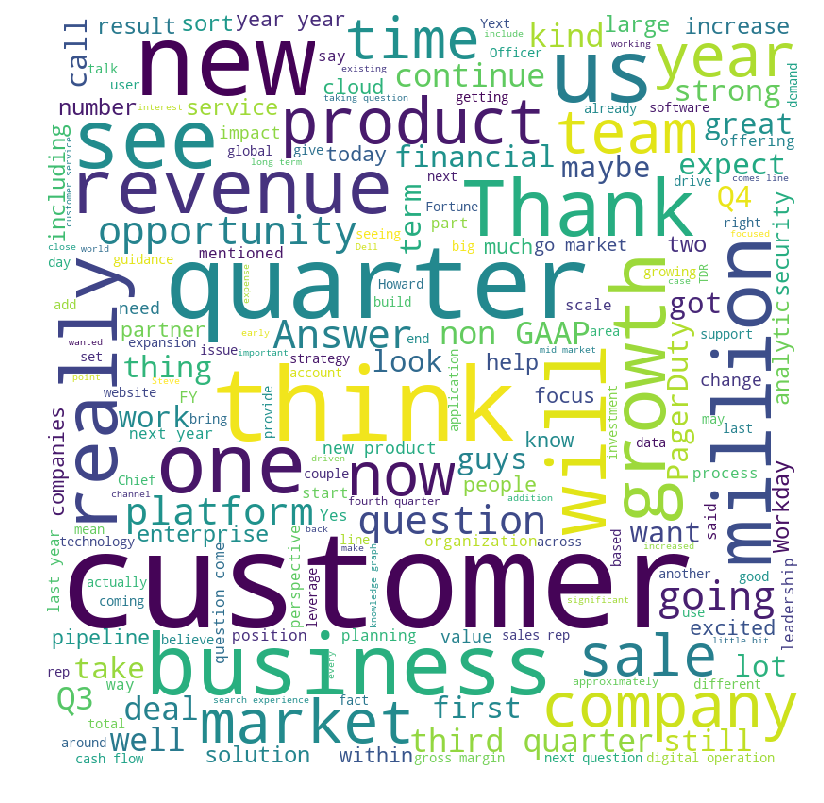

In [324]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(positive_data_words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Second, the negative words.

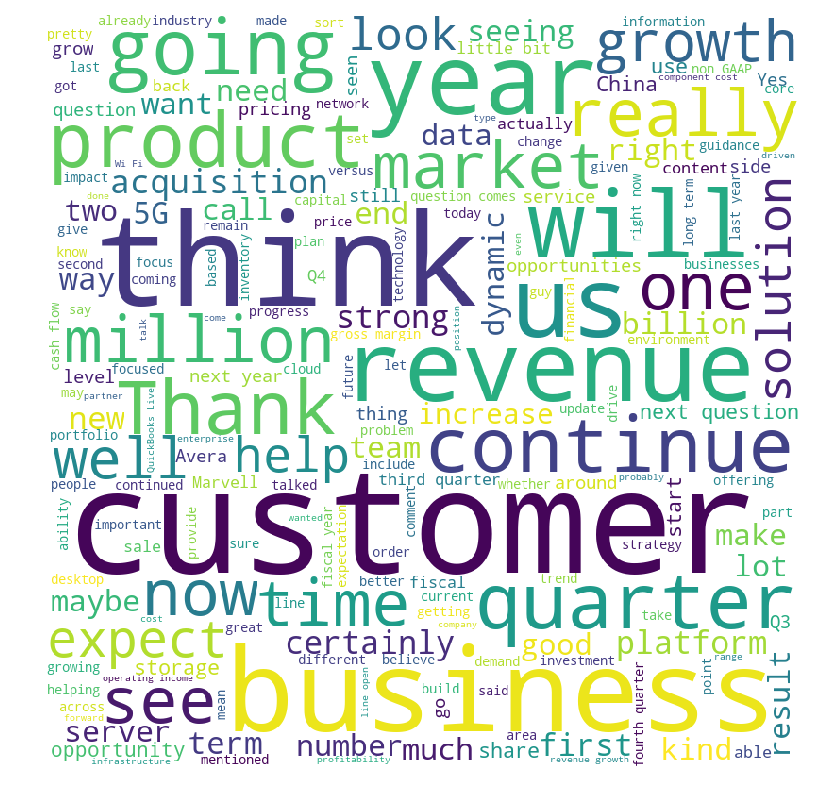

In [323]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(negative_data_words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

### Analysis
There are some interesting observations to be made. It is not surprising that there is overlap between the two lists, despite their differences. The same language clearly tends to be used in the earnings calls. Among the positive calls, we see words like growth, strategy, increase. However, we do not see explicitly negative words in the other wordclouds. One interesting observation is that the negative dataset references the upcoming quarter (fourth) more while the positive dataset references the previous quarter (third).

## Topic Modelling
In order to better understand the ideas or topics that make up these earnings calls, we also wanted to implement topic modelling. Our goal is to create a simple topic model on select trascripts, to study how the algorithm works and what its potential applications would be in our experiment.

### Imports
We begin with imports. Most notable is gensim. Gensim is an open source library for unsupervised topic modeling and natural language processing. We also define our stopwords, or words that we want to filter out. 

The stopwords here are general business jargon, that will be standardly and frequently used across all texts.

In [287]:
import re
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['fiscal', 'customer', 'revenue', 'business', 'think', 'year', 'quarter', 'price', 'thank', 'see'])                   
                   

[nltk_data] Downloading package stopwords to
[nltk_data]     /ilab/users/brb122/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing
Need to tokenize the data from one of the scripts. For this example, we chose to use Dell Technologies.

In [257]:
def prep_topic_model(filepath):
    root = "Earnings_Transcripts/"
    
    data_words = []
    words = []
    
    with open(root + filepath, "r") as text_file:
        data = text_file.read().split('\n')
        for i in range(3, (len(data))):
            line = data[i]
            tokenized_words = line.split(' ')
            if len(tokenized_words) > 2:
                words += tokenized_words
    
    data_words.append(words)
    return data_words

data_words_returned = prep_topic_model("DELL.txt")

### Build the bigram and trigram models
We need to build bigram and trigram models. Bigrams are pairnings of related words, and trigrams are groupings of 3.

In [258]:
bigram = gensim.models.Phrases(data_words_returned, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_returned], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Functionalization, Lemmatization, Stopwords
We wanted to create functions that would aid in building bigram and trigram models of our word lists. We also implemented lemmatization. Lemmatization is a process where a word is stripped of inflectional endings like tense so that the meaning of the word is isolated. 

In [259]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Put all of the Code Together
In the correct order, create bigrams from the text list. Call the lemmatization function, and initialize the dictionary and corpus needed for modelling. The printed reult represents word vectors for the bigrams.

In [260]:
data_words_nostops = remove_stopwords(data_words_returned)

data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatize your bigrams, tag
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print("{} ...(truncated)".format(corpus[0][:25]))

[(0, 5), (1, 2), (2, 2), (3, 2), (4, 1), (5, 4), (6, 2), (7, 2), (8, 4), (9, 1), (10, 1), (11, 1), (12, 5), (13, 6), (14, 1), (15, 1), (16, 1), (17, 14), (18, 1), (19, 3), (20, 2), (21, 2), (22, 3), (23, 1), (24, 1)] ...(truncated)


### Create the Model
Create the model using the id2word vector, along with specific parameters.

In [261]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=10,
                                           update_every=5,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

### Print Results
We can print the results with the following code in a human-readable format.

In [262]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"mention" + 0.001*"see" + 0.001*"pc" + 0.001*"environment" + '
  '0.001*"grow" + 0.001*"share" + 0.001*"base" + 0.001*"new" + 0.001*"demand" '
  '+ 0.001*"unit"'),
 (1,
  '0.001*"environment" + 0.001*"right" + 0.001*"want" + 0.001*"good" + '
  '0.001*"strong" + 0.001*"growth" + 0.001*"profitability" + 0.001*"product" + '
  '0.001*"mention" + 0.001*"customer"'),
 (2,
  '0.001*"server" + 0.001*"storage" + 0.001*"question" + 0.001*"dynamic" + '
  '0.001*"growth" + 0.001*"make" + 0.001*"take" + 0.001*"give" + 0.001*"see" + '
  '0.001*"continue"'),
 (3,
  '0.001*"storage" + 0.001*"see" + 0.001*"end" + 0.001*"say" + 0.001*"take" + '
  '0.001*"share" + 0.001*"expect" + 0.001*"demand" + 0.001*"growth" + '
  '0.001*"talk"'),
 (4,
  '0.001*"storage" + 0.001*"give" + 0.001*"question" + 0.001*"server" + '
  '0.001*"see" + 0.001*"product" + 0.001*"continue" + 0.001*"growth" + '
  '0.001*"say" + 0.001*"look"'),
 (5,
  '0.011*"server" + 0.009*"continue" + 0.009*"take" + 0.009*"storage" 

### Analysis

Presently, the topics are sparse and somewhat difficult to understand. There is significant overlap in terminology. However, there are some good examples here, that with some further modifications, could be promising. For example, we see the following topic collection:

#### (5, '0.011*"server" + 0.009*"continue" + 0.009*"take" + 0.009*"storage" + 0.008*"see" + 0.008*"dynamic" + 0.008*"question" + 0.008*"make" + 0.007*"give" + 0.007*"go")
  
The numbers are the weightings for how much the word. while it is still unclear, it seems that they are discussing server technology, with mentions of dynamic storage. This makes sense in the context of Dell as a company.

### Visualize

We've gone ahead and hand-selected some other descriptive examples from companies that reported both good and bad earnings. The data is entered manually. We've visualized these below. The green bars are companies with good earnings, and the red bars are for poor earnings

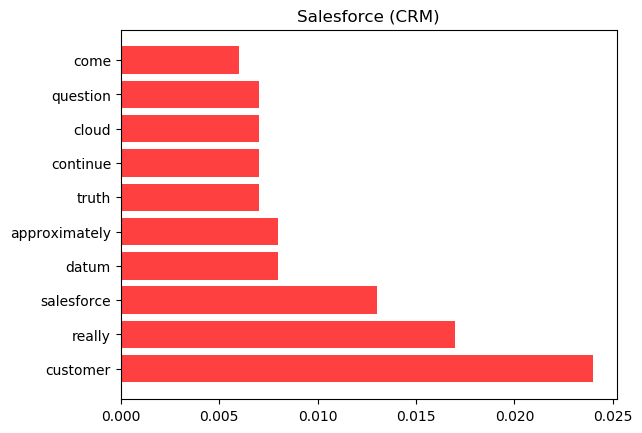

In [283]:
objects = ('customer', 'really', 'salesforce', 'datum', 'approximately', 'truth', 'continue', 'cloud', 'question', 'come')
performance = [0.024, 0.017, 0.013, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.006]
plt.barh(y_pos, performance, align='center', alpha=.75, color='red')
plt.yticks(y_pos, objects)
plt.title('Salesforce (CRM)')
plt.show()

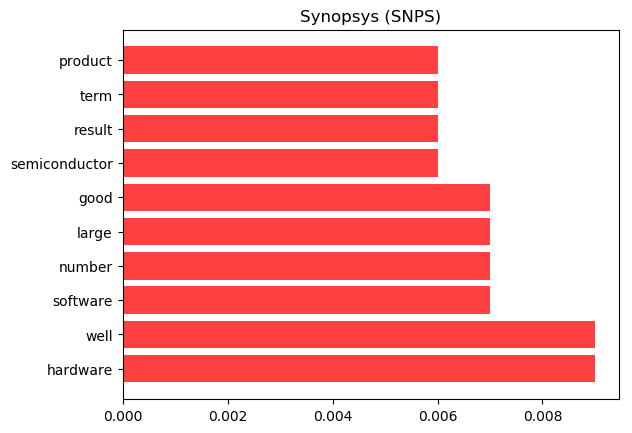

In [284]:
objects = ('hardware', 'well', 'software', 'number', 'large', 'good', 'semiconductor', 'result', 'term', 'product')
performance = [0.009, 0.009, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006]
plt.barh(y_pos, performance, align='center', alpha=.75, color='red')
plt.yticks(y_pos, objects)
plt.title('Synopsys (SNPS)')
plt.show()

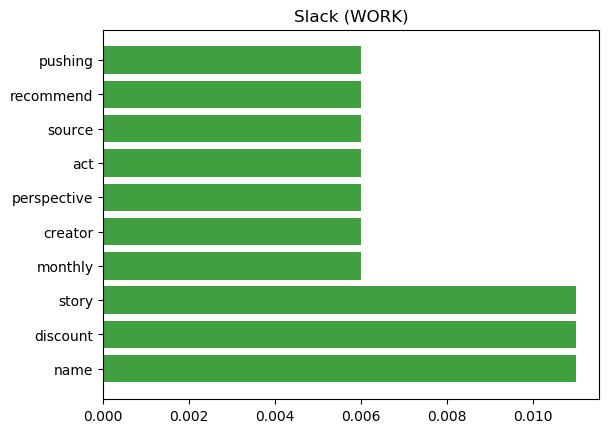

In [285]:
objects = ('name', 'discount', 'story', 'monthly', 'creator', 'perspective', 'act', 'source', 'recommend', 'pushing')
performance = [0.011, 0.011, 0.011, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006]
plt.barh(y_pos, performance, align='center', alpha=.75, color='green')
plt.yticks(y_pos, objects)
plt.title('Slack (WORK)')
plt.show()

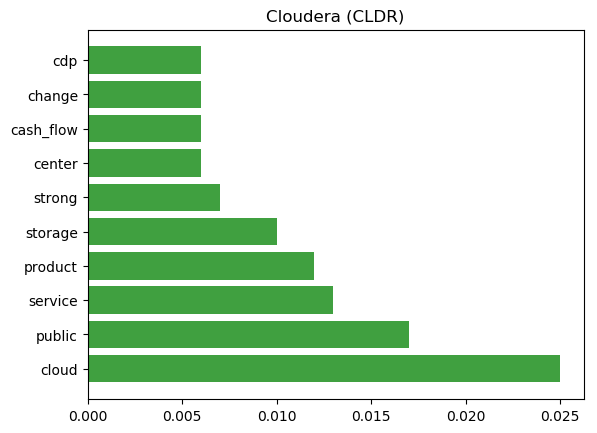

In [286]:
objects = ('cloud', 'public', 'service', 'product', 'storage', 'strong', 'center', 'cash_flow', 'change', 'cdp')
performance = [0.025, 0.017, 0.013, 0.012, 0.010, 0.007, 0.006, 0.006, 0.006, 0.006]
plt.barh(y_pos, performance, align='center', alpha=.75, color='green')
plt.yticks(y_pos, objects)
plt.title('Cloudera (CLDR)')
plt.show()

## Conclusion

This project exposed us to many different techniques. We were able to get a working bag of words classifier up and running, and saw that language is just one crucial parameter that informs investor decisions. By looking at the word breakdowns and asking ourselves questions about the content that make up these calls we gained a better understanding of how everything is interrelated. We think that this project just scratches the surface of some of these questions. With more time and research, we could help pinpoint how the word choice represents meaning, and how we can utilize this meaning as a learnable computer algorithm.